# Reconstruction of the 3D ALD sample with probe retrieval

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from holotomocupy.proc import linear, dai_yuan
from holotomocupy.tomo import R,RT
from holotomocupy.chunking import gpu_batch
from holotomocupy.utils import *

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)
detector_pixelsize = 3e-6
energy = 17.05  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8


In [3]:
psi_abs = read_tiff('data/rec_abs.tiff')[:]
psi_angle = read_tiff('data/rec_angle.tiff')[:]
psi = psi_abs*np.exp(1j*psi_angle)

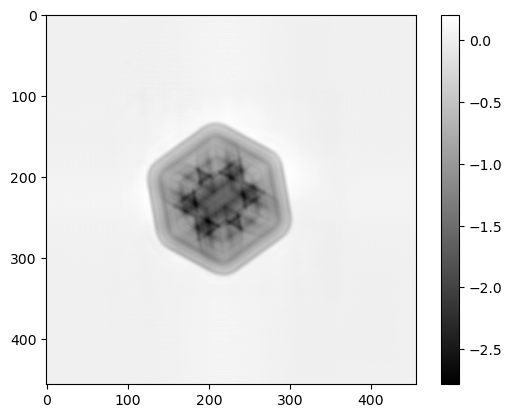

In [4]:
plt.imshow(np.angle(psi[0]),cmap='gray')
plt.colorbar()

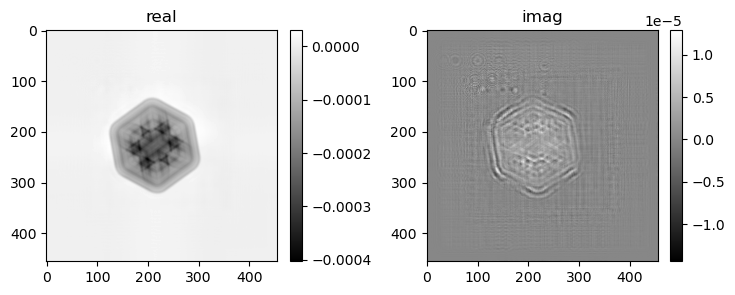

In [5]:
data = -1j*wavelength/(2*np.pi)*np.log(psi)/voxelsize

mshow_complex(data[0])


0) gamma=1, err=6.08220e-02


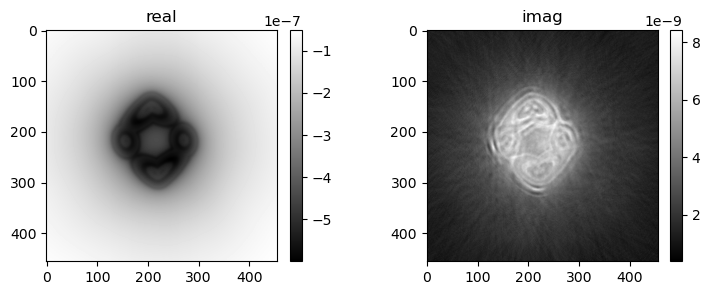

4) gamma=1, err=9.57019e-03
8) gamma=1, err=3.35710e-03
12) gamma=1, err=1.71203e-03
16) gamma=1, err=1.27108e-03


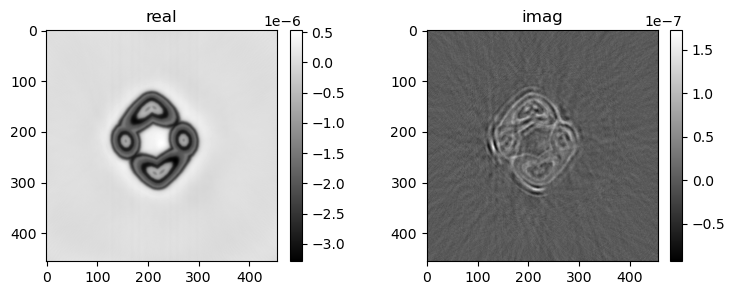

20) gamma=1, err=1.01534e-03
24) gamma=1, err=9.11145e-04
28) gamma=1, err=8.62356e-04
32) gamma=1, err=8.39930e-04


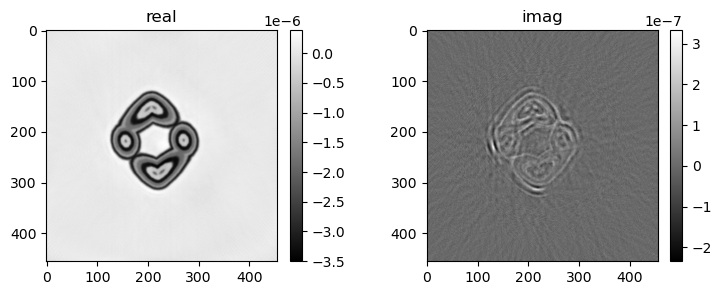

36) gamma=1, err=8.28692e-04
40) gamma=1, err=8.23303e-04
44) gamma=1, err=8.19540e-04
48) gamma=1, err=8.17273e-04


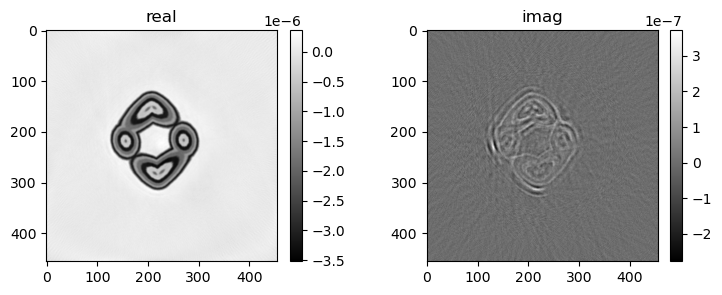

52) gamma=1, err=8.15918e-04
56) gamma=1, err=8.15160e-04
60) gamma=1, err=8.14640e-04
64) gamma=1, err=8.14324e-04


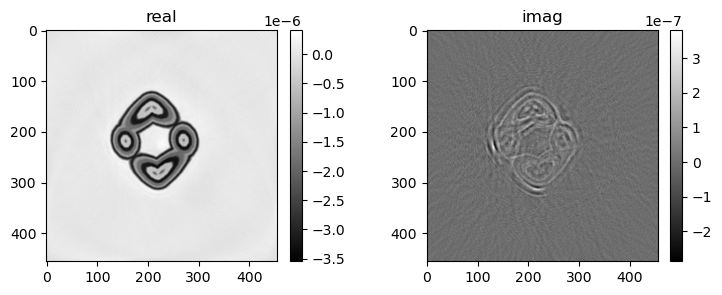

In [6]:


def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    conv = np.zeros(1+pars['niter']//pars['err_step'])
    
    for i in range(pars['niter']):
        fu = R(u,theta,center*ne/n)
        grad = RT(fu-data,theta,center*ne/n)/np.float32(ne*ntheta)
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center*ne/n)
        gamma = line_search(minf, pars['gamma'], fu, fd)
        u = linear(u,d,1,gamma)
        if i % pars['err_step'] == 0:
            fu = R(u, theta, center*ne/n)
            err = minf(fu)
            conv[i//pars['err_step']] = err
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_complex(u[ne//2])
            
    return u, conv


pars = {'niter': 65, 'err_step': 4, 'vis_step': 16, 'gamma': 1}

# if by chunk on gpu
# rec = np.zeros([ne,ne,ne],dtype='complex64')
# data_rec = data.swapaxes(0,1)

# if fully on gpu
rec = cp.zeros([ne,ne,ne],dtype='complex64')
data_rec = cp.array(data.swapaxes(0,1))
rec, conv = cg_tomo(data_rec, rec, pars)

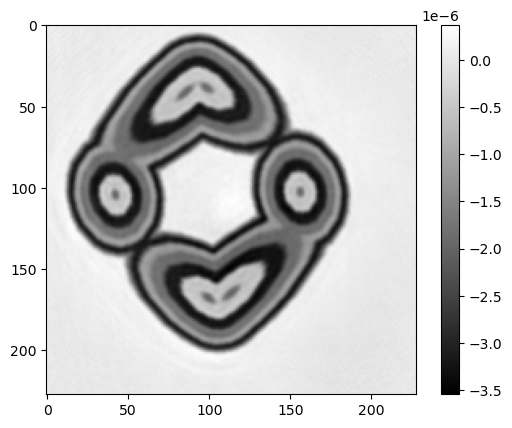

In [7]:
plt.imshow(rec[ne//2,ne//4:-ne//4,ne//4:-ne//4].real.get(),cmap='gray')
plt.colorbar()